In [4]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np

import matplotlib as mpl

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

from geocube.api.core import make_geocube
from typing import List

# Utils functions


In [5]:
##### GRID FACTORIES #####
def create_grid(
    gdf: None,
    bounds: List[float] | None = None,
    n_cells=10,
    overlap=False,
    crs="EPSG:4326",
):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            # print (gdf.overlay(poly, how='intersection'))
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells


def create_hex_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:4326"):
    """Hexagonal grid over geometry.
    See https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html
    """

    from shapely.geometry import Polygon
    import geopandas as gpd

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    unit = (xmax - xmin) / n_cells
    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * unit)
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, unit)

    # print (len(cols))
    hexagons = []
    for x in cols:
        for i, y in enumerate(rows):
            if i % 2 == 0:
                x0 = x
            else:
                x0 = x + 1.5 * unit

            hexagons.append(
                Polygon(
                    [
                        (x0, y * a),
                        (x0 + unit, y * a),
                        (x0 + (1.5 * unit), (y + unit) * a),
                        (x0 + unit, (y + (2 * unit)) * a),
                        (x0, (y + (2 * unit)) * a),
                        (x0 - (0.5 * unit), (y + unit) * a),
                    ]
                )
            )

    grid = gpd.GeoDataFrame({"geometry": hexagons}, crs=crs)
    grid["grid_area"] = grid.area
    grid = grid.reset_index().rename(columns={"index": "grid_id"})
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        grid = grid.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return grid


def create_size_based_grid(
    gdf: None,
    bounds: List[float] | None = None,
    size=256,
    predicate="within",
    crs="EPSG:2154",
    epsg: int | None = None,
):
    """Create square grid of fixed size (beware of crs unit) that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    """
    from shapely import Polygon
    from geopandas import GeoDataFrame, sjoin
    from numpy import arange

    gdf_to_merge = gdf
    gdf_to_merge["merge"] = 1
    gdf_merged = gdf_to_merge.dissolve("merge")

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf_merged.total_bounds

    cols = list(arange(xmin, xmax + size, size))
    rows = list(arange(ymin, ymax + size, size))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(
                Polygon(
                    [
                        (x, y),
                        (x + size, y),
                        (x + size, y + size),
                        (x, y + size),
                    ]
                )
            )
    if epsg != None:
        grid = GeoDataFrame({"geometry": polygons}, epsg=epsg)
    else:
        grid = GeoDataFrame({"geometry": polygons}, crs=crs)
    if predicate != None:
        grid = sjoin(grid, gdf_merged, how="inner", predicate=predicate)
    grid.insert(1, "id", range(1, 1 + len(grid)))
    grid = grid.reset_index()
    grid = grid[["id", "geometry"]]
    return grid


##### IGN GEOPORTAIL WEBSERVICES #####
from typing import Union, List

Num = Union[int, float]


def stringify_bbox(bounds: List[Num]) -> str:
    """
    Receive bounding box as a list and return it as a formatted string
    """
    xmin, ymin, xmax, ymax = bounds
    return f"{xmin},{ymin},{xmax},{ymax}"


def get_tile_url(
    base_url="https://wxs.ign.fr/ortho/geoportail/r/wms",
    layer_name="ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
    bbox="785802.3085941937752,6336806.404346071184,786208.1537742479704,6337311.468582574278",
    size=256,
) -> str:
    """
    Helper to format geoservices web expert URL

    Args:
      base_url:  "https://wxs.ign.fr/ortho/geoportail/r/wms" | "https://wxs.ign.fr/orthohisto/geoportail/r/wms"
      layer_name: layer service; see IGN geoservices doc for details:
              - Ortho https://geoservices.ign.fr/services-web-experts-ortho
              - Orthohisto https://geoservices.ign.fr/services-web-experts-orthohisto
      bbox: bounding box param, see `stringify_bbox` function to get formatted parrams from geopandas bounding box

    Returns:
      Formatted URI with params
    """
    params = f"SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={bbox}&CRS=EPSG:2154&WIDTH={size}&HEIGHT={size}&LAYERS={layer_name}&STYLES=&FORMAT=image/geotiff&DPI=72&MAP_RESOLUTION=72&FORMAT_OPTIONS=dpi:72"
    return f"{base_url}?{params}"


def download_image_from_url(
    url=None, index=None, out_path="./downloads/tiles", default_images_folder="default"
):
    import time
    from urllib.parse import urlparse, parse_qs
    import requests
    import os

    if url is None:
        raise ValueError("url param s required")

    t0 = time.time()
    parsed_url = urlparse(url)
    layer_param = parse_qs(parsed_url.query)["LAYERS"][0]
    bbox_param = parse_qs(parsed_url.query)["BBOX"][0]
    bbox_tuple = tuple(map(float, bbox_param.split(",")))

    if layer_param in [
        "ORTHOIMAGERY.ORTHOPHOTOS.IRC",
        "ORTHOIMAGERY.ORTHOPHOTOS.IRC-EXPRESS.2021",
        "ORTHOIMAGERY.ORTHOPHOTOS.IRC-EXPRESS.2023",
    ]:
        out_dir = f"{out_path}/irc"
    elif layer_param in [
        "ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
        "ORTHOIMAGERY.ORTHOPHOTOS.ORTHO-EXPRESS.2021",
        "ORTHOIMAGERY.ORTHOPHOTOS.ORTHO-EXPRESS.2023",
    ]:
        out_dir = f"{out_path}/ortho"
    else:
        out_dir = f"{out_path}/{default_images_folder}"

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    try:
        r = requests.get(url)
        if r.status_code == 200:
            if index is None:
                image_path = f"{out_dir}/image_{hash(bbox_tuple)}.tiff"
            else:
                image_path = f"{out_dir}/image_{index}.tiff"
            with open(image_path, "wb") as f:
                f.write(r.content)
            return (image_path, time.time() - t0, url)
        else:
            return (None, None, url)
    except Exception as e:
        print("Exception in download_url():", e)


##### PLOTTING UTILS #####
def plot_trio(ortho, irc, mask):
    import rasterio
    import matplotlib.pyplot as plt

    # Paths to the three raster images
    image_paths = [ortho, irc, mask]

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through the image paths and plot each image
    for i, image_path in enumerate(image_paths):
        with rasterio.open(image_path) as src:
            # Read the image data
            img_data = src.read()

            # Plot the image using imshow
            axes[i].imshow(
                img_data.transpose((1, 2, 0))
            )  # Transpose to (height, width, bands) for RGB images
            axes[i].set_title(f"Image {i + 1}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def plot_trio_from_index(index, dataset_path="./datasets"):
    import rasterio
    import matplotlib.pyplot as plt

    # Paths to the three raster images
    image_paths = [
        f"{dataset_path}/images/ortho/image_{index}.tiff",
        f"{dataset_path}/images/irc/image_{index}.tiff",
        f"{dataset_path}/masks/mask_{index}.tif",
    ]

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through the image paths and plot each image
    for i, image_path in enumerate(image_paths):
        with rasterio.open(image_path) as src:
            # Read the image data
            img_data = src.read()

            # Plot the image using imshow
            axes[i].imshow(
                img_data.transpose((1, 2, 0))
            )  # Transpose to (height, width, bands) for RGB images
            axes[i].set_title(f"Image {i + 1}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def plot_area_and_grid(area_gdf, grid_gdf, title="Geoplot 1"):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(14, 7))
    area_gdf.plot(ec="gray", fc="none", figsize=(10, 10), ax=ax)
    grid_gdf.plot(fc="none", ec="black", ax=ax)
    ax.set_title(title)


##### DATA TRANSFORMATIONS #####
def labels_to_mask_with_geocube(
    gdf, index, size=256, resolution=1, out_path="./datasets/masks"
):
    from geocube.api.core import make_geocube

    # Using GeoCube to rasterize the Vector
    mask_geocube = make_geocube(
        vector_data=gdf,
        measurements=["eunis_niv1_label"],
        resolution=(-resolution, resolution),
        fill=0,
    )

    # Save raster census raster
    mask_geocube.rio.to_raster(f"{out_path}/mask_{index}.tif")
    return f"{out_path}/mask_{index}.tif"


# TODO: refact this function to allow multithread processing
def create_4_band_training_raster(gdf, index, out_path="./datasets/images/training"):
    import rasterio
    from rasterio.plot import reshape_as_raster, reshape_as_image
    import os

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    (minx, miny, maxx, maxy) = gdf.total_bounds
    ortho_url = get_tile_url(
        base_url="https://wxs.ign.fr/orthohisto/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.ORTHO-EXPRESS.2021",
        bbox=f"{minx},{miny},{maxx},{maxy}",
    )
    irc_url = get_tile_url(
        base_url="https://wxs.ign.fr/orthohisto/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.IRC-EXPRESS.2021",
        bbox=f"{minx},{miny},{maxx},{maxy}",
    )
    (ortho_path, ortho_time, d_ortho_url) = download_image_from_url(
        url=ortho_url, index=index, out_path="./datasets/images"
    )
    (irc_path, irc_time, d_irc_url) = download_image_from_url(
        url=irc_url, index=index, out_path="./datasets/images"
    )

    train_path = f"{out_path}/image_{index}.tif"
    # Open the RGB image
    with rasterio.open(ortho_path) as rgb_src:
        # Read RGB data and metadata
        rgb_data = rgb_src.read()
        metadata = rgb_src.meta.copy()

    # Open the nir image
    with rasterio.open(irc_path) as infrared_src:
        # Read infrared data
        infrared_data = infrared_src.read(2)

    # Combine RGB and infrared data into a four-band array
    four_band_data = [rgb_data[0], rgb_data[1], rgb_data[2], infrared_data]
    # Update metadata for the new four-band raster
    metadata.update(count=4)

    # Create a new raster file and write the four-band data
    with rasterio.open(train_path, "w", **metadata) as dst:
        for i, band in enumerate(four_band_data, start=1):
            dst.write(band, i)

    return (ortho_path, irc_path, train_path)

# REMOTE SOURCE FILES


In [ ]:
# Liens data.montpellier3m.fr
poles_zonage_3m_url = "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_PolesZonage_0.zip"

occsol_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_OccupSol.zip"
)


def download_extract_delete_remote_archives(archives_urls, out_folder="./data/3m"):
    import os
    import requests
    import shutil
    import zipfile

    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    # Download the archive ; to do serialize this
    for index, url in enumerate(archives_urls):
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Get the filename from the response headers
            content_disposition = response.headers.get("Content-Disposition")
            if content_disposition:
                filename = content_disposition.split("filename=")[1].strip('"')
            else:
                # If no filename is provided in the headers, the endtrail of url
                filename = url.split("/")[-1]

            # Create the path for the downloaded archive
            archive_path = os.path.join(
                out_folder, filename
            )  # Adjust for different archive types

            # Save the downloaded content to the archive file
            with open(archive_path, "wb") as archive_file:
                archive_file.write(response.content)

            # Extract the archive
            extract_folder = os.path.join(
                out_folder, os.path.splitext(os.path.basename(archive_path))[0]
            )
            with zipfile.ZipFile(archive_path, "r") as zip_ref:
                zip_ref.extractall(extract_folder)

            # Optionally, delete the downloaded archive
            os.remove(archive_path)

            print(
                f"Archive downloaded, extracted, and deleted successfully to: {extract_folder}"
            )
        else:
            print(f"Failed to download archive. Status code: {response.status_code}")

In [ ]:
# Download resource files
download_extract_delete_remote_archives(
    archives_urls=[poles_zonage_3m_url],
    out_folder="./data/3m",
)

Archive downloaded, extracted, and deleted successfully to: ./data/3m/MMM_MMM_PolesZonage_0


(751380.8799999967, 788552.0799999967, 6261711.860000001, 6298883.0600000005)

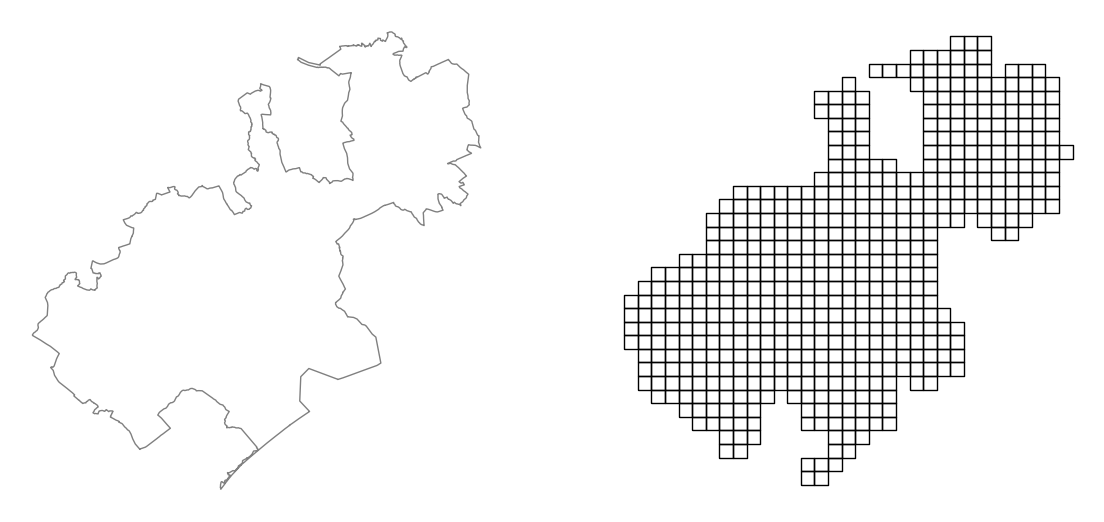

In [6]:
# Get administrative bondaries for study area (3Md)
boundaries = gpd.read_file(
    "./data/3m/MMM_MMM_PolesZonage_0/MMM_MMM_PolesZonage.shp", crs="EPSG:2154"
)

# merge bounndaries
boundaries_to_dissolve = boundaries
boundaries_to_dissolve["merge"] = 1
aoi = boundaries_to_dissolve.dissolve("merge")

grid_aoi = create_size_based_grid(gdf=boundaries, size=1024, predicate="intersects")
grid_aoi["size"] = grid_aoi["geometry"].length / 4

# Plot 3M grid and landcover layer

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
axs = ax.flat
aoi.plot(ec="gray", fc="none", figsize=(10, 10), ax=axs[0])
grid_aoi.plot(fc="none", ec="black", ax=axs[1])
axs[0].axis("off")
axs[1].axis("off")

In [7]:
grid_aoi.head()

,id,geometry,size
0,1,"POLYGON ((753070.480 6273641.460, 754094.480 6...",1024.0
1,2,"POLYGON ((753070.480 6274665.460, 754094.480 6...",1024.0
2,3,"POLYGON ((753070.480 6275689.460, 754094.480 6...",1024.0
3,4,"POLYGON ((753070.480 6276713.460, 754094.480 6...",1024.0
4,5,"POLYGON ((754094.480 6270569.460, 755118.480 6...",1024.0


In [8]:
# TODO: refact this function to allow multithread processing
def create_4_band_input_raster(
    gdf, index, size=1024, out_path="./datasets/inputs/images"
):
    import rasterio
    from rasterio.plot import reshape_as_raster, reshape_as_image
    import os

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    (minx, miny, maxx, maxy) = gdf.total_bounds
    ortho_url = get_tile_url(
        base_url="https://wxs.ign.fr/ortho/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
        bbox=f"{minx},{miny},{maxx},{maxy}",
        size=size,
    )
    irc_url = get_tile_url(
        base_url="https://wxs.ign.fr/ortho/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.IRC",
        bbox=f"{minx},{miny},{maxx},{maxy}",
        size=size,
    )
    (ortho_path, ortho_time, d_ortho_url) = download_image_from_url(
        url=ortho_url, index=index, out_path=out_path
    )
    (irc_path, irc_time, d_irc_url) = download_image_from_url(
        url=irc_url, index=index, out_path=out_path
    )

    input_folder = f"{out_path}/4bands"
    if not os.path.exists(input_folder):
        os.makedirs(input_folder)

    input_path = f"{input_folder}/image_{index}.tiff"
    # Open the RGB image
    with rasterio.open(ortho_path) as rgb_src:
        # Read RGB data and metadata
        rgb_data = rgb_src.read()
        metadata = rgb_src.meta.copy()

    # Open the nir image
    with rasterio.open(irc_path) as infrared_src:
        # Read infrared data
        infrared_data = infrared_src.read(2)

    # Combine RGB and infrared data into a four-band array
    four_band_data = [rgb_data[0], rgb_data[1], rgb_data[2], infrared_data]
    # Update metadata for the new four-band raster
    metadata.update(count=4)

    # Create a new raster file and write the four-band data
    with rasterio.open(input_path, "w", **metadata) as dst:
        for i, band in enumerate(four_band_data, start=1):
            dst.write(band, i)

    return (ortho_path, irc_path, input_path)

In [ ]:
for index, geometry in grid_aoi["geometry"].items():
    clipped = grid_aoi.clip(geometry)
    (ortho_path, irc_path, input_path) = create_4_band_input_raster(clipped, index)
    print(input_path)

# Generate input data in HDF5 format


In [ ]:
def save_h5_input_dataset(images, filename):
    import h5py
    import os

    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("images", data=images)

    # ---- done
    size = os.path.getsize(filename) / (1024 * 1024)
    print(
        "Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)".format(
            filename, str(images.shape), size
        )
    )

In [ ]:
IMAGES_DIR = "./datasets/inputs/images/4bands"
from PIL import Image
from pathlib import Path
import os
import numpy as np
from rasterio.plot import reshape_as_image


def raster_to_nparray(raster):
    pass


image_names = []
for file in Path(IMAGES_DIR).glob("*.tiff"):
    fileName = Path(file).stem + ".tiff"
    image_names.append(os.path.join(IMAGES_DIR, fileName))
image_names.sort()


images = [np.asarray(Image.open(image)) for image in image_names]
image_dataset = np.array(images)

print(image_dataset.shape)

(38, 1024, 1024, 4)


In [ ]:
H5_FILE = "./h5/input_01.h5"
save_h5_input_dataset(image_dataset, H5_FILE)

Dataset : ./h5/input_01.h5          shape : (38, 1024, 1024, 4)    size :  152.0 Mo   (saved)


In [ ]:
# Archive input data